In [2]:
import pandas as pd
import re
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [15]:
# Set NLTK data directory using environment variable
nltk.data.path.append('/Users/leoking/Desktop/final_project')




In [4]:
# Read the CSV file
data = pd.read_csv("stock_tweets.csv").copy()

In [20]:
print(data.shape)
data.head()

(80793, 5)


,Date,Tweet,Stock Name,Company Name,cleaned_text
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",Mainstream media has done an amazing job at br...
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",Tesla delivery estimates are at around 364k fr...
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",3 Even if I include 63 0M unvested RSUs as of ...
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",RealDanODowd WholeMarsBlog Tesla Hahaha why ar...
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",RealDanODowd Tesla Stop trying to kill kids yo...


In [24]:


# Example preprocessed tweets
preprocessed_tweets = [
    "great day for the markets",
    "stocks are plummeting",
    "earnings report was positive",
    "market uncertainty due to global events"
]

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=80700)  # You can adjust max_features as needed
X = vectorizer.fit_transform(preprocessed_tweets)

# X is now a sparse matrix containing the TF-IDF features
print(X.toarray())


[[0.         0.4472136  0.         0.         0.         0.4472136
  0.         0.4472136  0.         0.4472136  0.         0.
  0.         0.         0.4472136  0.         0.         0.        ]
 [0.57735027 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.57735027 0.
  0.         0.57735027 0.         0.         0.         0.        ]
 [0.         0.         0.         0.5        0.         0.
  0.         0.         0.         0.         0.         0.5
  0.5        0.         0.         0.         0.         0.5       ]
 [0.         0.         0.40824829 0.         0.40824829 0.
  0.40824829 0.         0.40824829 0.         0.         0.
  0.         0.         0.         0.40824829 0.40824829 0.        ]]


In [28]:
stocks = pd.read_csv("stock_yfinance_data.csv")
stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [31]:
date_intervals = ['1 hour', '2 hours', '1 day']  # Define time intervals

for interval in date_intervals:
    data[f'stock_movement_{interval}'] = 'neutral'  # Initialize labels
    
    for index, tweet_row in data.iterrows():
        tweet_time = tweet_row['Date']  # Use 'Date' column
        
        # Find the index of the row with the same timestamp in stocks DataFrame
        stock_row_index = stocks[stocks['Date'] == tweet_time].index
        
        if len(stock_row_index) > 0:
            stock_row_index = stock_row_index[0]  # Get the first matching index
            
            # Find the stock price at the beginning and end of the interval
            stock_price_begin = stocks.loc[stock_row_index, 'Close']
            stock_price_end_index = stock_row_index + pd.Timedelta(interval)
            stock_price_end = stocks.loc[stock_price_end_index, 'Close']
            
            if stock_price_end > stock_price_begin:
                data.at[index, f'stock_movement_{interval}'] = 'up'
            elif stock_price_end < stock_price_begin:
                data.at[index, f'stock_movement_{interval}'] = 'down'

In [ ]:
data

In [33]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/leoking/nltk_data...


True

In [35]:
X = data['cleaned_text']
y = data['sentiment_label']

In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [45]:
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_test_tfidf

<16159x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 330026 stored elements in Compressed Sparse Row format>

In [51]:
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)
rf_predictions = rf_classifier.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)
print(classification_report(y_test, rf_predictions))

Random Forest Accuracy: 0.7918188006683582
              precision    recall  f1-score   support

    negative       0.92      0.43      0.59      3281
     neutral       0.80      0.80      0.80      4656
    positive       0.77      0.93      0.84      8222

    accuracy                           0.79     16159
   macro avg       0.83      0.72      0.74     16159
weighted avg       0.81      0.79      0.78     16159



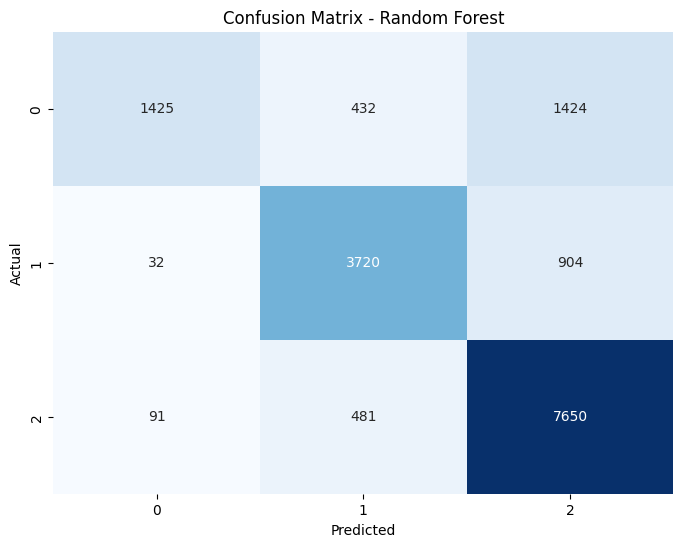

In [48]:
# Confusion matrix for Random Forest
rf_cm = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [52]:
# Support Vector Machines (SVM)
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)
svm_predictions = svm_classifier.predict(X_test_tfidf)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)
print(classification_report(y_test, svm_predictions))

SVM Accuracy: 0.8929389194875921
              precision    recall  f1-score   support

    negative       0.86      0.75      0.80      3281
     neutral       0.87      0.93      0.90      4656
    positive       0.92      0.93      0.92      8222

    accuracy                           0.89     16159
   macro avg       0.88      0.87      0.87     16159
weighted avg       0.89      0.89      0.89     16159



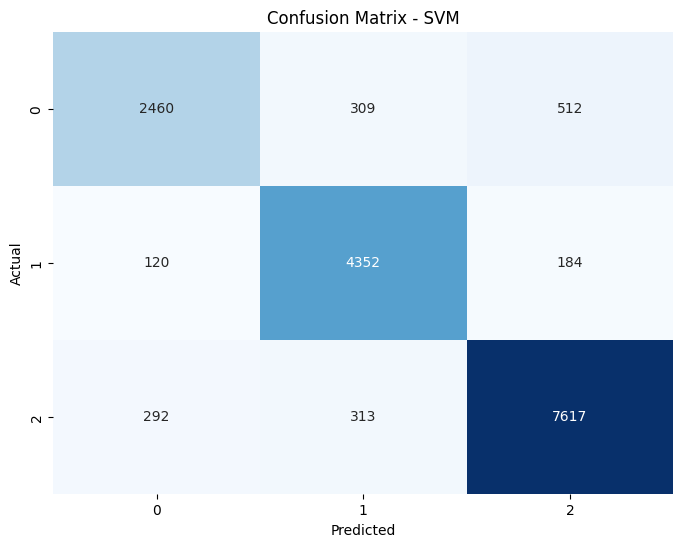

In [53]:
svm_cm = confusion_matrix(y_test, svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [54]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
nb_predictions = nb_classifier.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)
print(classification_report(y_test, nb_predictions))

Naive Bayes Accuracy: 0.6928646574664273
              precision    recall  f1-score   support

    negative       0.85      0.38      0.52      3281
     neutral       0.83      0.45      0.58      4656
    positive       0.64      0.96      0.77      8222

    accuracy                           0.69     16159
   macro avg       0.78      0.59      0.63     16159
weighted avg       0.74      0.69      0.67     16159



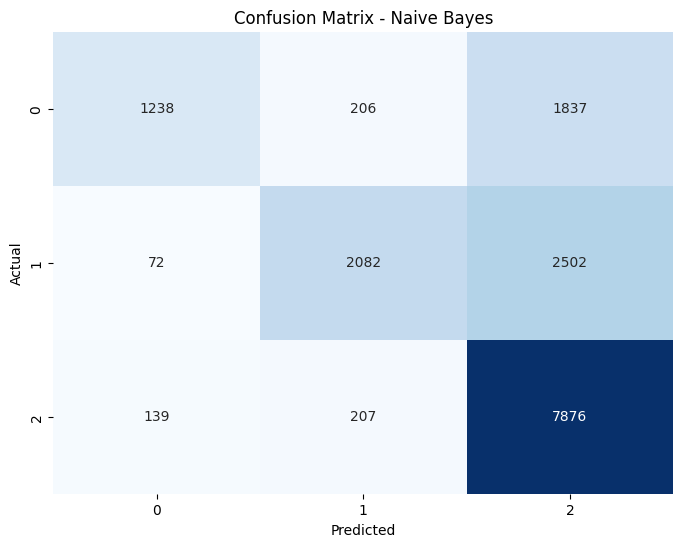

In [55]:
# Confusion matrix for Naive Bayes
nb_cm = confusion_matrix(y_test, nb_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [58]:
# Merge the tweets DataFrame with the historical stock movement data
merged_df = pd.merge(data, stocks, on='Date', how='left').copy()

# Define a function to label stock movement based on price change
def label_stock_movement(row):
    if row['Close'] > row['Open']:
        return 'up'
    elif row['Close'] < row['Open']:
        return 'down'
    else:
        return 'neutral'

# Apply the function to generate stock movement labels
merged_df['stock_movement'] = merged_df.apply(label_stock_movement, axis=1)

# Prepare data for stock movement prediction model
X_stock = merged_df['cleaned_text']
y_stock = merged_df['stock_movement']

# Split the data into training and testing sets
X_train_stock, X_test_stock, y_train_stock, y_test_stock = train_test_split(X_stock, y_stock, test_size=0.2, random_state=42)

# Create TF-IDF vectorizer
vectorizer_stock = TfidfVectorizer(max_features=1000)  # You can adjust max_features as needed
X_train_tfidf_stock = vectorizer_stock.fit_transform(X_train_stock)
X_test_tfidf_stock = vectorizer_stock.transform(X_test_stock)

# Train a Random Forest classifier for stock movement prediction
rf_classifier_stock = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_stock.fit(X_train_tfidf_stock, y_train_stock)
rf_predictions_stock = rf_classifier_stock.predict(X_test_tfidf_stock)

# Evaluate the model
rf_accuracy_stock = accuracy_score(y_test_stock, rf_predictions_stock)
print("Random Forest Stock Movement Prediction Accuracy:", rf_accuracy_stock)
print(classification_report(y_test_stock, rf_predictions_stock))


Random Forest Stock Movement Prediction Accuracy: 1.0
              precision    recall  f1-score   support

     neutral       1.00      1.00      1.00     16159

    accuracy                           1.00     16159
   macro avg       1.00      1.00      1.00     16159
weighted avg       1.00      1.00      1.00     16159

